In [33]:
import numpy as np; import matplotlib.pyplot as plt;
import ipywidgets as widgets; from ipywidgets import interact;
from ipywidgets.widgets import *
import numpy.random as rnd; from numpy import *;
from shared import *;
from matplotlib import rc;
rc('text', usetex=True)

In [2]:
def pdf2d(rv1, rv2, bins=25, density=True):

    pxy, xedg, yedg = np.histogram2d(rv1, rv2, bins=bins, density=density)

    extents = (xedg[-1] - xedg[0], yedg[-1] - yedg[0])
    xedg = (xedg[0:-1] + xedg[1:]) / 2
    yedg = (yedg[0:-1] + yedg[1:]) / 2

    return pxy, xedg, yedg, extents

In [3]:
def plotpdf2d(rv1, rv2, bins=25):
    # pdf computation
    pxy, xedg, yedg, extents = pdf2d(rv1, rv2, bins=bins)
    # Reshape for plot
    pxy_1d = np.reshape(pxy, (1, bins**2))[0]
    xedg = kron(np.ones((1,bins)), xedg)[0]
    yedg = kron(yedg, np.ones((1,bins)))[0]
    # Plotting
    ax = plt.axes(projection='3d')
    ax.bar3d(xedg, yedg, zeros_like(xedg), extents[0]/bins, extents[1]/bins, pxy_1d)
    plt.show()

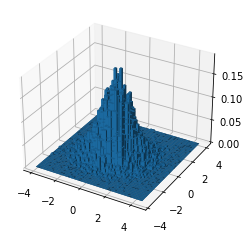

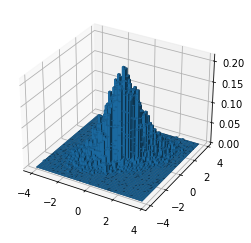

In [4]:
N = 20000

rv = rnd.multivariate_normal([0,0], [[1,0],[0,1]], size=N)
rv_dep = rnd.multivariate_normal([0,0],[[1,0.5],[0.5,1]], size=N)

plotpdf2d(rv[:,0], rv[:,1], bins=49)
plotpdf2d(rv_dep[:,0], rv_dep[:,1], bins=49)

In [5]:
# Fourierova transformacija
import scipy.fft as fft

def fun(n):
    w = linspace(-10, 10, 10000)
    X = sinc(w)
    Y = X**n

    plt.plot(w, Y)
    plt.show()
interact(fun, n=widgets.IntSlider(1, 1, 40));

interactive(children=(IntSlider(value=1, description='n', max=40, min=1), Output()), _dom_classes=('widget-int…

In [6]:
def multivariate_gaussian(x, mean, cov):
    x = array(x); mean = array(mean); cov = array(cov)
    k = x.shape[0] # Broj varijabli
    n = x.shape[1] # Broj ulaznih koordinata
    
    # Provjera ulaznih parametara
    #if len(x.shape) != 1:
        #raise Exception('Neispravan vektor ulaznih promjenljivih x');
    #if shape(cov)[0] != shape(cov)[1] or any(cov != cov.T) or any(linalg.eig(cov) < 0):
        #raise Exception('Neispravna kovarijantna matrica')
    #TODO provjere
    
    inv_cov = matrix(linalg.inv(cov))
    inv_det = linalg.det(inv_cov)
    
    y = empty(n)
    for j in range(n):
        x_m = matrix(x)[:,j] - matrix(mean).T
        y[j] = sqrt(exp(- x_m.T * inv_cov * x_m).T * inv_det / (2*pi)**k)
    
    return y

In [92]:
def plot_multivariate_gaussian(mean, cov, N=100):
    # Generisanje vektora ulaznih varijabli
    
    elipsa = cov_elipsa(mean, cov)
    # Određivanje prihvatljivih granica oblasti
    xlim = [mean[0]-elipsa[2]*1.8, mean[0]+elipsa[2]*1.8]
    ylim = [mean[1]-elipsa[3]*1.8, mean[1]+elipsa[3]*1.8]
    
    # Generisanje vektora koordinata
    x = linspace(xlim[0], xlim[1], N)
    y = linspace(ylim[0], ylim[1], N)
    _X,_Y = meshgrid(x, y)
    X = _X.flatten(); Y = _Y.flatten()

    # Računanje raspodjele
    p = multivariate_gaussian(stack((X,Y)), mean, cov)
    
    #################

    fig = plt.figure(figsize=(4,8.5))
    ax = fig.add_subplot(2,1,1, projection='3d')
    
    # Crtanje raspodjele
    ax.plot_surface(_X, _Y, p.reshape(N,N), cmap='hot')
    
    # Crtanje marginalnih raspodjela
    ax.plot3D(X, ylim[1]*ones_like(X),
              gaussian(X, mean[0], cov[0][0]) * sqrt(cov[0][0]/(2*pi*linalg.det(cov))),
              c='orchid', label='$p_X(x)$')
    ax.plot3D(xlim[0]*ones_like(Y), Y,
              gaussian(Y, mean[1], cov[1][1]) * sqrt(cov[1][1]/(2*pi*linalg.det(cov))),
              c='dodgerblue', label='$p_Y(y)$')
    
    plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.legend(bbox_to_anchor=(0.7,1))
    
    # Crtanje konturnog grafika
    ax = fig.add_subplot(2,1,2)
    ax.contourf(_X, _Y, p.reshape(N,N), 50, cmap='hot', antialiased=False)
    
    # Srednja vrijednost
    ax.scatter(mean[0], mean[1], c='k', label='Očekivanje')
    
    # Elipsa kovarijanse
    ax.plot(elipsa[0], elipsa[1], label='Elipsa kovarijanse')
    
    plt.legend(bbox_to_anchor=(1.02,1.02), framealpha=1); plt.show()
    step = diff(xlim)*diff(ylim)/N**2

In [91]:
def vizualizacija_multivar_gauss(meanX, meanY, varX, varY, covXY, N=100):
    mean = [meanX, meanY]
    cov = [[varX, covXY],[covXY, varY]]
    plot_multivariate_gaussian(mean, cov, N)
    
meanX=FloatSlider(0, min=-10, max=10, step=0.05)
meanY=FloatSlider(0, min=-10, max=10, step=0.05)
varX=FloatSlider(1, min=0.001, max=20, step=0.05)
varY=FloatSlider(1, min=0.001, max=20, step=0.05)
covXY=FloatSlider(0, min=-0.9999, max=0.9999, step=0.05)
N=IntSlider(20, min=1, max=200)

def on_change(change):
    val = sqrt(varX.value * varY.value)
    covXY.min = -val + 0.001
    covXY.max = val - 0.001
    
varX.observe(on_change, 'value')
varY.observe(on_change, 'value')
    
interact(vizualizacija_multivar_gauss, meanX=meanX, meanY=meanY,
         varX=varX, varY=varY, covXY=covXY, N=N);

interactive(children=(FloatSlider(value=0.0, description='meanX', max=10.0, min=-10.0, step=0.05), FloatSlider…

31.218749999984766
-896.5634765616728


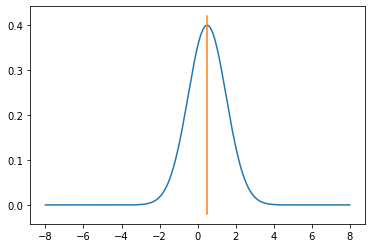

In [9]:
x = linspace(-8, 8, 1000)
T = (x[-1] - x[0]) / 1000
p = gaussian(x, mean=0.5)
plt.plot(x, p)
plt.plot([0.5,0.5], list(plt.ylim()))
m = pdf_mean(x, p)
v = pdf_var(x, p)
print(m)
print(v)